In [1]:
!pip install pydot

In [2]:
import tensorflow as tf
from dataloader import Dataset
from data_generator import FrameGenerator
from model import build_model
from tensorflow import keras

2023-03-19 16:27:26.499780: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
data, classes = Dataset(
    dataset_path="dataset/UCF-101", 
    num_classes=40, 
    splits={"train": 60, "val": 50, "test": 100}
    )
    
for split in data.keys():
    print(split, len(data[split]))

Total Number of Videos: 5313
train 3175
val 1061
test 1077


In [4]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

FrameGenerator(data['train'], n_frames, classes, training=True)

train_ds = tf.data.Dataset.from_generator(FrameGenerator(data['train'], n_frames, classes, training=True), output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(data['val'], n_frames, classes), output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(data['test'], n_frames, classes), output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

2023-03-19 16:27:28.544009: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-19 16:27:28.552818: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-19 16:27:28.827848: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-19 16:27:28.827899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 30 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 312.97GiB/s
2023-03-19 16:27:28.827911: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-19 16:27:28.862819: I tensorflow/stream_executor/platfor

In [5]:
HEIGHT = 224
WIDTH = 224
input_shape = (None, 10, HEIGHT, WIDTH, 3)

model = build_model(input_shape[1:])

frames, label = next(iter(train_ds))

model.build(frames)

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 8, 222, 222, 16)   1312      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 6, 220, 220, 32)   13856     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 218, 218, 64)   55360     
_________________________________________________________________
dropout (Dropout)            (None, 4, 218, 218, 64)   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 216, 216, 64)   110656    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 108, 108, 64)   0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 746496)         0

2023-03-19 16:27:30.695396: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-19 16:27:30.697515: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600010000 Hz


In [6]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [7]:
tf.__version__

'2.4.1'

In [11]:
checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 )
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

restore_training_callback = tf.keras.callbacks.experimental.BackupAndRestore("tmp")

In [12]:
model.load_weights("checkpoints/cp-0003.ckpt")

In [13]:
history = model.fit(x = train_ds, epochs = 50, validation_data = val_ds, callbacks=[checkpoint_callback, early_stop_callback])



Epoch 1/50
397/397 [==============================] - 443s 1s/step - loss: 0.7469 - accuracy: 0.9115 - val_loss: 0.7659 - val_accuracy: 0.9133
Epoch 2/50
397/397 [==============================] - 448s 1s/step - loss: 0.6572 - accuracy: 0.9294 - val_loss: 0.7339 - val_accuracy: 0.9152
Epoch 3/50
397/397 [==============================] - 451s 1s/step - loss: 0.5459 - accuracy: 0.9572 - val_loss: 0.6464 - val_accuracy: 0.9246
Epoch 4/50
397/397 [==============================] - 448s 1s/step - loss: 0.4825 - accuracy: 0.9635 - val_loss: 0.6337 - val_accuracy: 0.9199
Epoch 5/50
397/397 [==============================] - 436s 1s/step - loss: 0.4310 - accuracy: 0.9682 - val_loss: 0.6001 - val_accuracy: 0.9274
Epoch 6/50
397/397 [==============================] - 442s 1s/step - loss: 0.3794 - accuracy: 0.9751 - val_loss: 0.5955 - val_accuracy: 0.9161
Epoch 7/50
397/397 [==============================] - 465s 1s/step - loss: 0.3402 - accuracy: 0.9795 - val_loss: 0.5843 - val_accuracy: 0.9208

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_ds, return_dict=True)

In [19]:
!pip install matplotlib==3.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 9.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [24]:
import matplotlib.pyplot as plt
import numpy as np

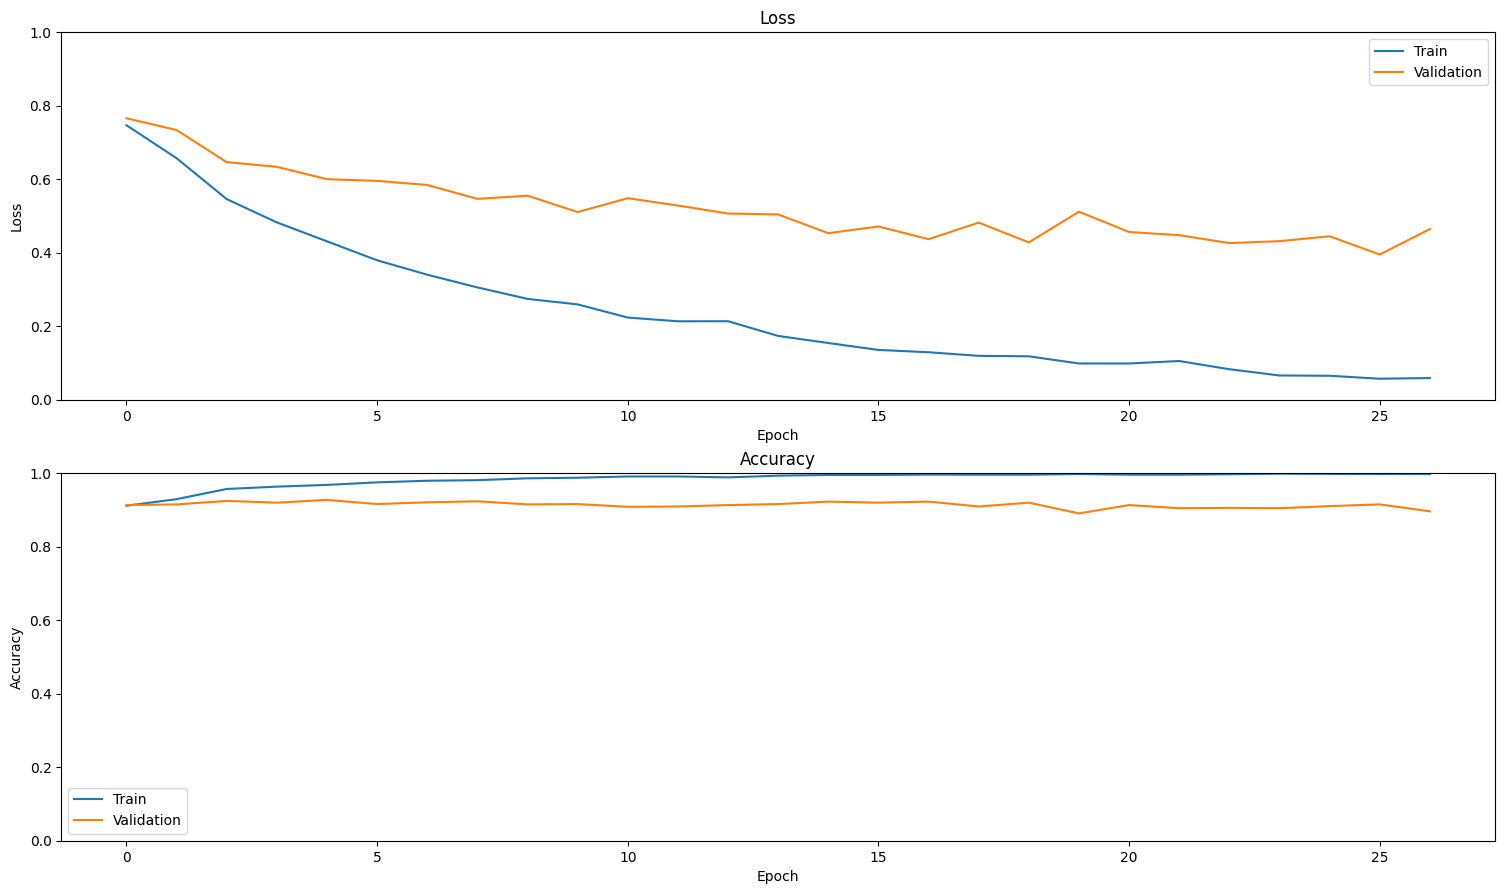

In [25]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)


In [30]:
model.load_weights("checkpoints/cp-0005.ckpt")

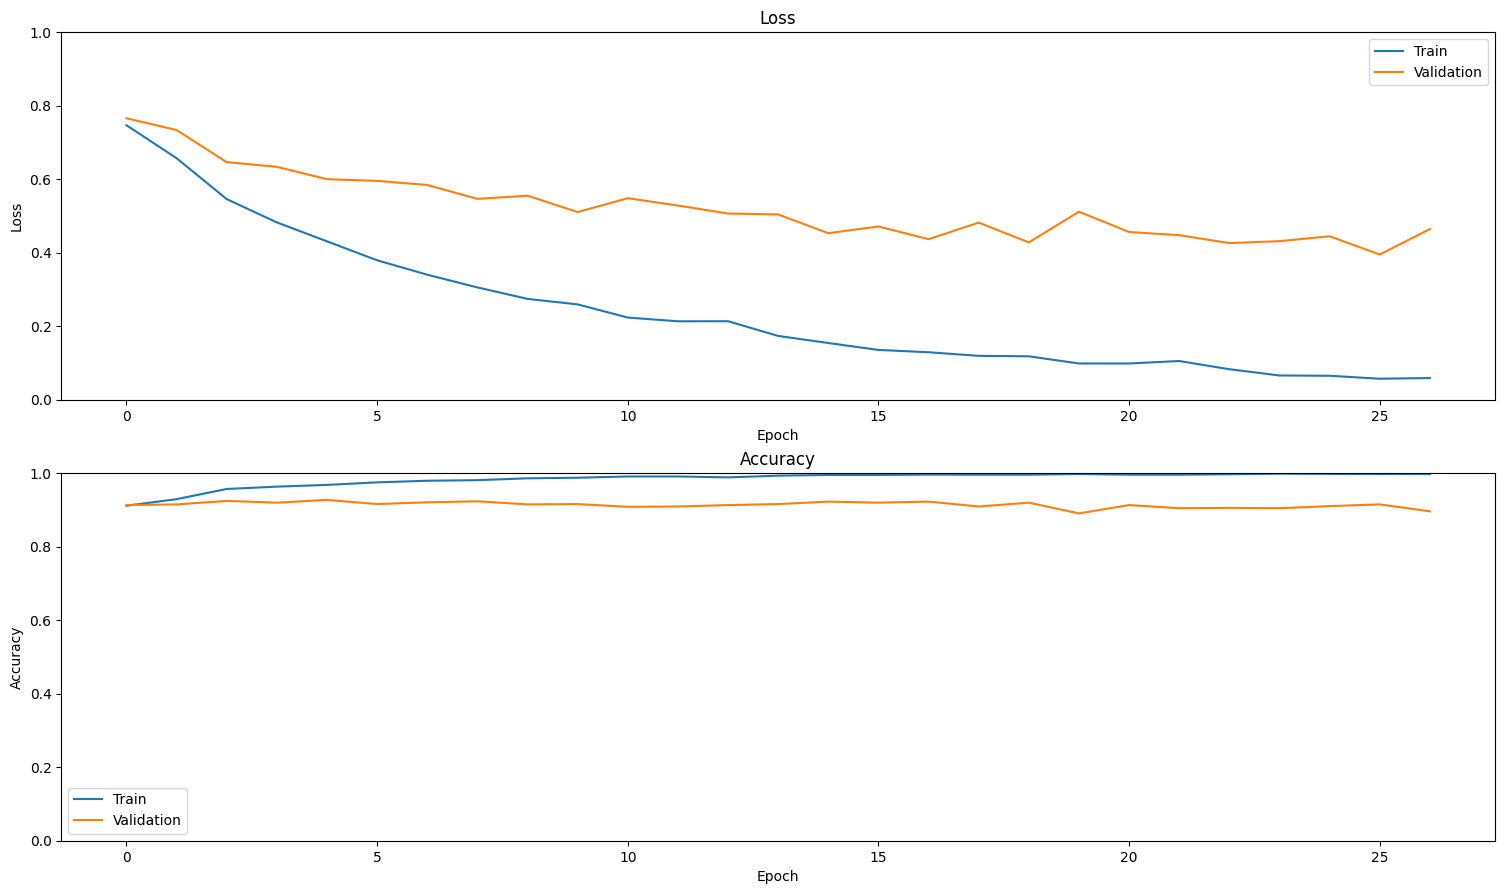

In [31]:
hist = model.history
plot_history(hist)

In [32]:
model.evaluate(test_ds, return_dict=True)

135/135 [==============================] - 78s 576ms/step - loss: 0.6260 - accuracy: 0.9211


{'loss': 0.6260426640510559, 'accuracy': 0.9210770726203918}

In [33]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [34]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [37]:

classes

['BlowingCandles',
 'Biking',
 'Bowling',
 'Basketball',
 'CricketShot',
 'BoxingSpeedBag',
 'HammerThrow',
 'FieldHockeyPenalty',
 'BenchPress',
 'Fencing',
 'HighJump',
 'CuttingInKitchen',
 'BlowDryHair',
 'BreastStroke',
 'Diving',
 'HeadMassage',
 'Archery',
 'FrontCrawl',
 'Billiards',
 'HandstandWalking',
 'CliffDiving',
 'ApplyEyeMakeup',
 'BandMarching',
 'GolfSwing',
 'BaseballPitch',
 'CleanAndJerk',
 'BalanceBeam',
 'Hammering',
 'HandstandPushups',
 'BasketballDunk',
 'BabyCrawling',
 'FloorGymnastics',
 'ApplyLipstick',
 'CricketBowling',
 'FrisbeeCatch',
 'BrushingTeeth',
 'Haircut',
 'BodyWeightSquats',
 'BoxingPunchingBag',
 'Drumming']

In [39]:
actual, predicted = get_actual_predicted_labels(test_ds)


In [53]:
!pip install seaborn==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [54]:
import seaborn as sns

AttributeError: module 'numpy' has no attribute '_no_nep50_warning'

In [ ]:
plot_confusion_matrix(actual, predicted, classes, 'test')